# Lista 4 de Visão Computacional
Alunos: LUCAS HERON SANTOS ANCHIETA RUAN TENÓRIO DE MELO

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from ultralytics import YOLO

In [ ]:
def show_images(images, titles = None, cmap=None):
  n = len(images)
  plt.figure(figsize=(20, 10))
  for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(images[i], cmap=cmap)
    if titles is not None:
      plt.title(titles[i])
    plt.axis('off')
  plt.show()

## Questão 1 
As fotografias em modo retrato se popularizaram nos  últimos anos. Elas consistem em segmentar foreground e background em uma fotografia, e borrar o background, simulando o efeito de uma câmera DLSR, como na imagem localizada em (./img/q1-camera.jpg).

O objetivo dessa questão é simular este efeito, usando mapas de disparidade gerados por duas imagens. Para um tutorial de como gerar mapas de disparidade usando OpenCV, veja https://docs.opencv.org/4.7.0/dd/d53/tutorial_py_depthmap.html. Após a aquisição do mapa de disparidade, você deve usá-lo adequadamente para detectar o foreground, aplicar um filtro gaussiano para borrar apenas o background, e combinar as duas partes para obter um efeito como na figura acima. Experimente seu algoritmo em três pares de imagens, em cenários diferentes, adquiridas através de pequenas variações de ponto de vista da câmera.

In [ ]:
window_size = 3
# num_disp = 112-min_disp
num_disp = 16 * 6
block_size = 9
def get_disparity_map(imgL, imgR, min_disp=0):
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        blockSize = block_size,
        P1 = 8 * 3 * window_size**2,
        P2 = 32 * 3 * window_size**2,
        disp12MaxDiff = 1,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32
    )
   
    disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    # disp_normalized = cv2.normalize(disp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity_map_bm_raw = stereo.compute(imgL, imgR)
    valid_mask = disparity_map_bm_raw >= 0
    disparity_to_normalize = np.where(valid_mask, disparity_map_bm_raw, 0)

    # # Normaliza apenas os valores válidos para 0-255 para visualização e thresholding simples
    disparity_map_normalized = cv2.normalize(disparity_to_normalize, None,
                                             alpha=0, beta=255,
                                             norm_type=cv2.NORM_MINMAX,
                                             dtype=cv2.CV_8U)
    return disparity_map_normalized

In [ ]:
def blurry_bg_with_disparity_map(imgL, disparity_map, threshold=70):
    ret, foreground_mask = cv2.threshold(disparity_map,
                                         threshold,
                                         255,
                                         cv2.THRESH_BINARY)
    foreground_mask = foreground_mask.astype(np.uint8)
    imgL_blurred = cv2.GaussianBlur(imgL, (55, 55), 0)

    foreground_mask_3ch = cv2.cvtColor(foreground_mask, cv2.COLOR_GRAY2BGR)

    show_images([imgL, imgL_blurred, foreground_mask_3ch], ['Original Image', 'Blurred Image', 'Foreground Mask'], cmap='gray')

    mask_boolean = foreground_mask_3ch.astype(bool)

    output_image = np.where(mask_boolean, imgL, imgL_blurred)
    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    imgL_blurred = cv2.cvtColor(imgL_blurred, cv2.COLOR_BGR2RGB)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    show_images([imgL, imgL_blurred, output_image], ['Original Image', 'Blurred Image', 'Output Image'], cmap='gray')

### Exemplo 1

In [ ]:
imgL = cv2.imread('./img/aloeL.jpg')
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR = cv2.imread('./img/aloeR.jpg')
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

disp = get_disparity_map(imgL_gray, imgR_gray, 16)
show_images([imgL_gray, disp], ['Left Image',  'Disparity Map'], cmap='gray')

In [ ]:
blurry_bg_with_disparity_map(imgL, disp, 160)

### Exemplo 2

In [ ]:
imgL = cv2.imread('./img/monopolyL.png')
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR = cv2.imread('./img/monopolyR.png')
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

disp = get_disparity_map(imgL_gray, imgR_gray)

show_images([imgL_gray, disp], ['Left Image',  'Disparity Map'], cmap='gray')

In [ ]:
blurry_bg_with_disparity_map(imgL,  disp, 79)

### Exemplo 3

In [ ]:
imgL = cv2.imread('./img/babyL.png')
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR = cv2.imread('./img/babyR.png')
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

disp = get_disparity_map(imgL_gray, imgR_gray)
show_images([imgL_gray, imgR_gray,disp], ['Left Image', "Right Image", 'Disparity Map'], cmap='gray')


In [ ]:
blurry_bg_with_disparity_map(imgL, disp, 90)

## Questão 2 
Leia o seguinte tutorial sobre reconstrução 3d, até a etapa de geração do arquivo PLY: https://medium.com/analytics-vidhya/depth-sensing-and-3d-reconstruction-512ed121aa60

### a) Experimente o código disponibilizado no tutorial em três exemplos distintos, gerando a nuvem de pontos e visualizando com o Meshlab.

In [ ]:
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [ ]:
data_folder_left = "data_road/training/image_2/"
data_folder_right = "data_road/training_right/image_3/"
data_folder_calib = "data_road/training/calib/"
cat = ['uu', 'uum', 'um']
IDX_LEN = 6

In [ ]:
idx_num = 1
cat_idx = 2
fname = cat[cat_idx]+'_'+str(idx_num).zfill(IDX_LEN)
img_fname = fname + '.png'
calib_fname = fname + '.txt'

In [ ]:
img_left_color = cv2.imread(data_folder_left + img_fname)
img_right_color = cv2.imread(data_folder_right + img_fname)

In [ ]:
img_left_bw = cv2.blur(cv2.cvtColor(img_left_color, cv2.COLOR_RGB2GRAY),(5,5))
img_right_bw = cv2.blur(cv2.cvtColor(img_right_color, cv2.COLOR_RGB2GRAY),(5,5))

In [ ]:
stereo = cv2.StereoBM_create(numDisparities=96, blockSize=11)
disparity = stereo.compute(img_left_bw,img_right_bw)

img = disparity.copy()
plt.imshow(img, 'CMRmap_r')

In [ ]:
matrix_type_1 = 'P2'
matrix_type_2 = 'P3'

calib_file = data_folder_calib + calib_fname
with open(calib_file, 'r') as f:
    fin = f.readlines()
    for line in fin:
        if line[:2] == matrix_type_1:
            calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
        elif line[:2] == matrix_type_2:
            calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)

In [ ]:
cam1 = calib_matrix_1[:,:3] # left image - P2
cam2 = calib_matrix_2[:,:3] # right image - P3

Tmat = np.array([0.54, 0., 0.])

rev_proj_matrix = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);

In [ ]:
points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = img > img.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
idx = np.fabs(out_points[:,0]) < 4.5
out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
out_colors = out_colors[idx]

write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

In [ ]:

reflected_pts = np.matmul(out_points, reflect_matrix)
projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                          cam2[:3,:3], np.array([0., 0., 0., 0.]))
projected_img = projected_img.reshape(-1, 2)


In [ ]:
blank_img = np.zeros(img_left_color.shape, 'uint8')
img_colors = img_right_color[mask][idx].reshape(-1,3)

for i, pt in enumerate(projected_img):
    pt_x = int(pt[0])
    pt_y = int(pt[1])
    if pt_x > 0 and pt_y > 0:
        # use the BGR format to match the original image type
        col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
        cv2.circle(blank_img, (pt_x, pt_y), 1, col)


In [ ]:
show_images([blank_img], ['Projected Image'], cmap='gray')

### b) Descreva, com suas palavras, as etapas realizadas desde o fornecimento do par de imagens de entrada, até a geração da nuvem de pontos em formato PLY.

## Questão 3 
Usando a plataforma Kaggle, pesquise um base supervisionada de imagens que possa ser usada para treinar um classificador binário de imagens. Esta base deve conter exemplos de duas classes. Considere 70% das amostras para treino, e 30% para teste (método holdout).

### a) Usando OpenCV, extraia descritores HOG (Histogram of Gradients), e treine um classificador SVM. Exiba a acurácia atingida no conjunto de teste e a matriz de confusão. Exiba exemplos. Obs.: note que essa abordagem é semelhante ao detector Dalal-Triggs, porém aqui estamos usando-a para classificação de imagens. 

### b) Agora o objetivo é treinar uma CNN. Usando a abordagem de transferência de aprendizado (transfer learning), realize treinamentos usando modelos VGG16, ResNet50, e MobileNetV2 pré-treinados. Compare os resultados usando acurácias e matrizes de confusão. Exiba exemplos de acerto e erro.

## Questão 4 
O objetivo dessa questão é criar um contador de veículos em vídeos de uma rodovia. Você deve experimentar um modelo pré-treinado da YOLO, e um Single Shot MultiBox Detection (SSD)

### a) Estude a SSD, e descreva suas principais diferenças em relação à YOLO.

### b) Para cada um dos dois modelos, realize as detecções de veículos em cada frame do vídeo em anexo (classroom). Gere os vídeos com as bounding boxes detectadas.

#### YOLO

In [ ]:
model = YOLO('yolov8n.pt')
video = "./img/bridge.mp4"
cap = cv2.VideoCapture(video)

output = "./img/bridge_out_yolo.mp4"
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output, fourcc, fps, (width, height))

yolo_qtd_cars = []

while cap.isOpened():   
    ret, frame = cap.read()
    if not ret: # If the video has ended, break the loop
        break

    results = model(frame, classes = [2,3,5], verbose=False)
    detections = results[0].boxes 

    qtd_cars = sum(1 for box in detections if box.cls == 2)
    yolo_qtd_cars.append(qtd_cars)

    annotated_frame = results[0].plot()

    out.write(annotated_frame)

    # cv2.imshow('YOLOv8 Detection', annotated_frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break
cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 9 cars, 1 bus, 134.2ms
Speed: 4.4ms preprocess, 134.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 213.0ms
Speed: 9.5ms preprocess, 213.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 286.0ms
Speed: 28.8ms preprocess, 286.0ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 348.9ms
Speed: 10.7ms preprocess, 348.9ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 227.9ms
Speed: 19.8ms preprocess, 227.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1394.9ms
Speed: 16.1ms preprocess, 1394.9ms inference, 33.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 bus, 525.5ms
Speed: 21.2ms preprocess, 525.5ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 bus, 638.9ms
Speed: 3.6ms preprocess

#### Single Shot MultiBox Detection (SSD)

In [36]:
model_ssd = cv2.dnn.readNetFromTensorflow("./models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb",
                                          "./models/ssd_mobilenet_v2_coco_2018_03_29/model.pbtxt")
video = "./img/bridge.mp4"
output = "./img/bridge_out_yolo.mp4"

CLASSES = { 3: "Car", 4: "Motorcycle", 6: "Bus", 8: 'Truck'}

cap = cv2.VideoCapture(video)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter("./img/bridge_out_ssd.mp4", fourcc, fps, (width, height))

ssd_qtd_cars = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    rows = frame.shape[0]
    cols = frame.shape[1]
    blob = cv2.dnn.blobFromImage(frame, size=(300, 300), swapRB=True)
    model_ssd.setInput(blob)
    cvOut = model_ssd.forward()
    qtdDetections = cvOut.shape[2]
    qtd_cars = 0
    for detection in cvOut[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        if score > 0.3:
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            class_id = int(detection[1])
            if class_id in CLASSES:
                if class_id == 3:
                    qtd_cars += 1
                label = f"{CLASSES[class_id]}: {score:.2f}"
                cv2.rectangle(frame, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), thickness=2)
                cv2.putText(frame, label, (int(left), int(top) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    ssd_qtd_cars.append(qtd_cars)
    # cv2.namedWindow("frame", cv2.WINDOW_NORMAL)
    # cv2.imshow("frame", frame)
    # if cv2.waitKey(1) >= 0:  # Break with ESC 
    #     break
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

### c) Para cada um dos dois modelos, plote um gráfico onde o eixo horizontal é o tempo (quadro do vídeo), e o vertical é a quantidade de carros detectada pelo modelo.

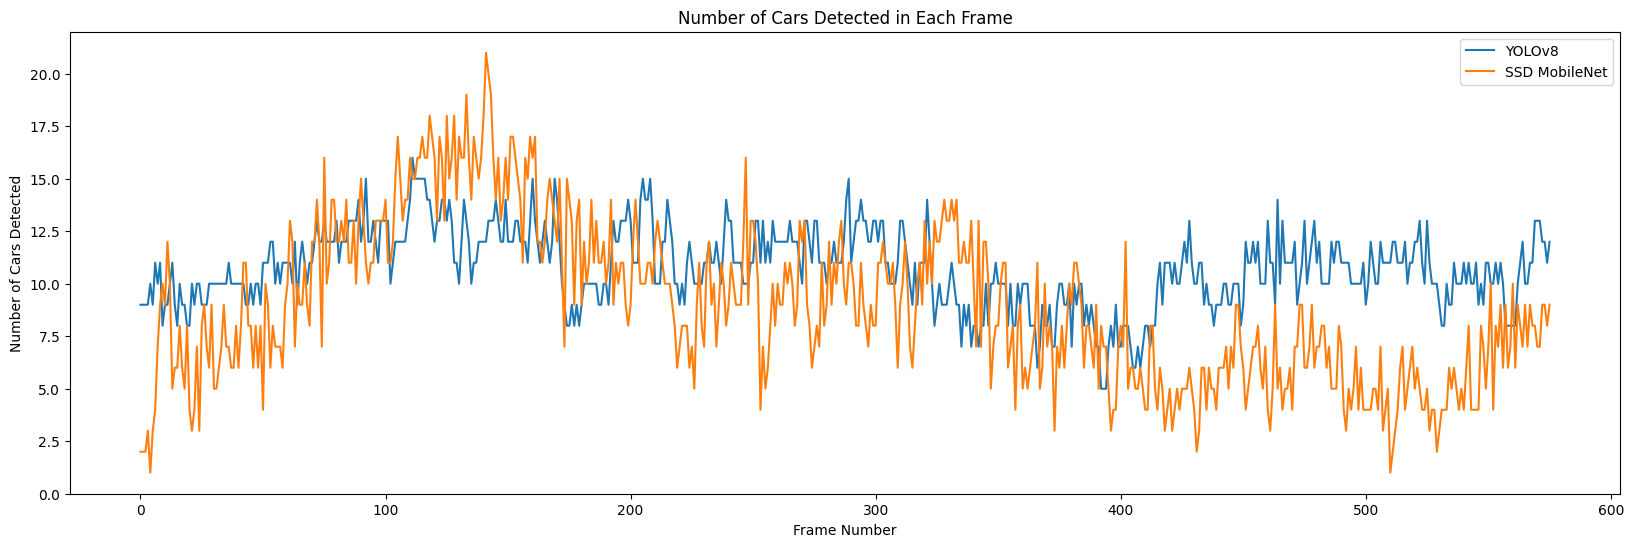

In [41]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(yolo_qtd_cars)), yolo_qtd_cars, label='YOLOv8')
plt.plot(range(len(ssd_qtd_cars)), ssd_qtd_cars, label='SSD MobileNet')
plt.xlabel('Frame Number')
plt.ylabel('Number of Cars Detected')
plt.title('Number of Cars Detected in Each Frame')
plt.legend()
plt.show()